# Using Information Theory to Determine which features affects Brainrot among students

In [23]:
import uuid
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, StandardScaler
from scipy.stats import norm
from sklearn.metrics.pairwise import pairwise_kernels

import statsmodels.api as sm

In [24]:
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle")

## Process Data

In [25]:
df = pd.read_csv("anonymous-brainrot.csv")
display(df)

,unique_id,race,race_complex,gender,gender_complex,grade,iphone,goon,stem,music,music_complex,insta,q1,q2,q3,q4,q5,q6,t1,t1_dirty
0,f41ecf4a-a1b7-49d1-a13e-601e7ff37b22,Indian,Indian,m,m,12,y,y,n,n,n,662,y,n,n,n,b,snake,41.58,41.58
1,26ce9a22-872d-42d6-8452-9e5174aae6ca,White,White,m,m,12,n,n,n,y,y,132,y,y,y,y,b,snake,36.89,36.89
2,46a4ca62-b78b-4a09-bf92-78edf47c733d,Indian,Indian,m,m,12,y,n,y,n,n,520,n,n,n,n,a,snake,32.83,32.83
3,44a2f3b7-bd6d-4557-968f-04e28136fa1c,Asian,Asian,f,f,12,y,n,n,n,n,300,n,y,n,n,b,snake,23.25,23.25
4,361615c6-632d-4647-bb68-225676f79224,Asian,Asian,f,f,12,y,y,y,y,cg,1273,y,y,y,n,b,cat,34.81,34.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0563fcaa-cf79-4e4b-8711-c385e51d3d05,Black/Hispanic,Black/Hispanic,m,m,11,y,n,n,n,theater,200,y,y,y,y,b,snake,62.00,62.00
97,d0573dec-2f94-4947-95e7-a4d0d438c679,Asian,Asian,m,m,11,y,n,y,y,y,50,n,y,n,n,b,snake,94.00,94.00
98,9bd74e6d-04d8-4f01-9f5f-81d11ac54d94,Asian,Asian,m,m,10,y,n,y,y,y,250,n,n,n,n,b,snake,19.00,19.00
99,156fc3b9-93f9-48fc-979d-1bf7ccd66d45,White,White,m,m,12,y,n,y,n,theater,818,y,y,y,y,b,snake,73.00,73.00


In [26]:
df.drop(columns=["unique_id", "race_complex", "gender_complex", "music_complex", "t1_dirty"], inplace=True)

# Map responses to something more understandable
map_yes_no = {'y':1, 'n':0}
map = {}
for col in ["q1", "q2", "q3", "q4"]:
    map[col] = map_yes_no
map["gender"] = {"m": "Male", "f": "Female"}
map["iphone"] = {"y":"iPhone", "n":"Android"}
map["goon"] = {"y":"goon", "n":"not goon"}
map["stem"] = {"y":"STEM", "n":"not STEM"}
map["music"] = {"y":"Band/Orchestra", "n":"Not in Music"}
map["grade"] = {9:"Freshmen", 10:"Sophomore", 11:"Junior", 12:"Senior"}
map["q5"] = {"a":0,"b":1,"c":0,"d":0}
map["q6"] = {"snake":1,"cat":0,"worm":0,"chinchilla":0}
df["q7"] = df["q6"].copy()
df = df.replace(map)

# Number of questions answered correctly
df["points"] = df[["q1", "q2", "q3", "q4", "q5", "q6"]].sum(axis=1)

# Weight the questions based on difficulty by calculating the log likelihood of answering a question correctly
p = df[["q1", "q2", "q3", "q4", "q5", "q6"]].mean()
log_likelihoods = df[["q1", "q2", "q3", "q4", "q5", "q6"]].apply(lambda x: x * np.log(p) + (1 - x) * np.log(1 - p), axis=1).mean()
weights = np.exp(log_likelihoods)
df_weighted_sum = df * (1/weights)
df['weighted_points'] = df_weighted_sum.sum(axis=1)

# Combine statistics of quiz points and angry bird video watch time
df["combined_points"] = df["weighted_points"] + df["t1"]*0.1

# Take log of instagram followers
# df["log_insta"] = df["insta"].apply(lambda x: math.log10(x+1))
df["insta"] = df["insta"].apply(lambda x: math.log10(x+1))

# Standardize some of the features
scaler = StandardScaler()
df['std_weighted_points'] = scaler.fit_transform(np.array(df['weighted_points']).reshape(-1, 1))
df['std_t1'] = scaler.fit_transform(np.array(df['t1']).reshape(-1, 1))
df["std_sum"] = df["std_weighted_points"] + df["std_t1"]
# Calculate percentile of brainrot level
df["pct"] = df["std_sum"].apply(lambda x: norm.cdf(x/2))

df.dropna(inplace=True)
display(df)

,race,gender,grade,iphone,goon,stem,music,insta,q1,q2,...,q6,t1,q7,points,weighted_points,combined_points,std_weighted_points,std_t1,std_sum,pct
0,Indian,Male,Senior,iPhone,goon,not STEM,Not in Music,2.821514,1,0,...,1,41.58,snake,3,4.939246,9.097246,-0.451772,0.008700,-0.443073,0.412337
1,White,Male,Senior,Android,not goon,not STEM,Band/Orchestra,2.123852,1,1,...,1,36.89,snake,6,10.805670,14.494670,1.409266,-0.173679,1.235587,0.731644
2,Indian,Male,Senior,iPhone,not goon,STEM,Not in Music,2.716838,0,0,...,1,32.83,snake,1,1.867234,5.150234,-1.426324,-0.331559,-1.757883,0.189716
3,Asian,Female,Senior,iPhone,not goon,not STEM,Not in Music,2.478566,0,1,...,1,23.25,snake,3,4.975008,7.300008,-0.440427,-0.704094,-1.144522,0.283573
4,Asian,Female,Senior,iPhone,goon,STEM,Band/Orchestra,3.105169,1,1,...,0,34.81,cat,4,7.031925,10.512925,0.212100,-0.254563,-0.042463,0.491530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Black/Hispanic,Male,Junior,iPhone,not goon,not STEM,Not in Music,2.303196,1,1,...,1,62.00,snake,6,10.805670,17.005670,1.409266,0.802767,2.212034,0.865640
97,Asian,Male,Junior,iPhone,not goon,STEM,Band/Orchestra,1.707570,0,1,...,1,94.00,snake,3,4.975008,14.375008,-0.440427,2.047143,1.606716,0.789116
98,Asian,Male,Sophomore,iPhone,not goon,STEM,Band/Orchestra,2.399674,0,0,...,1,19.00,snake,2,3.010293,4.910293,-1.063705,-0.869363,-1.933068,0.166889
99,White,Male,Senior,iPhone,not goon,STEM,Not in Music,2.913284,1,1,...,1,73.00,snake,6,10.805670,18.105670,1.409266,1.230521,2.639788,0.906565


## Compute HSIC Value

In [27]:
# Separate features and target
X = df.iloc[:, 1:9]
y = df.iloc[:, -2]

# One-hot encode categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
encoder = OneHotEncoder()

X_encoded = encoder.fit_transform(X[categorical_features]).toarray()

# Standardize numerical features
numerical_features = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_features])

# Combine encoded categorical and scaled numerical features
X_processed = np.hstack((X_encoded, X_scaled))

def centering_matrix(n):
    return np.eye(n) - np.ones((n, n)) / n

def compute_hsic(X, y, kernel='rbf'):
    m = X.shape[0]
    H = centering_matrix(m)
    K = pairwise_kernels(X, metric=kernel)
    # L = pairwise_kernels(np.reshape(y, (-1, 1)), metric=kernel)
    L = pairwise_kernels(y.values.reshape(-1, 1), metric=kernel)
    HSIC = np.trace(np.dot(np.dot(K, H), np.dot(L, H))) / (m ** 2)
    return HSIC

# Compute HSIC
hsic_value = compute_hsic(X_processed, y)
print(f"HSIC value: {hsic_value}")

# Permutation test to determine significance
def permutation_test(X, y, n_permutations=10000, kernel='rbf'):
    m = X.shape[0]
    H = centering_matrix(m)
    K = pairwise_kernels(X, metric=kernel)
    L = pairwise_kernels(y.values.reshape(-1, 1), metric=kernel)
    
    original_hsic = np.trace(np.dot(np.dot(K, H), np.dot(L, H))) / (m ** 2)
    permuted_hsics = []

    for _ in range(n_permutations):
        y_permuted = np.random.permutation(y)
        L_perm = pairwise_kernels(y_permuted.reshape(-1, 1), metric=kernel)
        hsic_perm = np.trace(np.dot(np.dot(K, H), np.dot(L_perm, H))) / (m ** 2)
        permuted_hsics.append(hsic_perm)

    p_value = np.mean(np.array(permuted_hsics) >= original_hsic)
    return original_hsic, p_value

# Perform permutation test
hsic_value, p_value = permutation_test(X_processed, y)
print(f"HSIC value: {hsic_value}, p-value: {p_value}")

HSIC value: 0.009100194756692019
HSIC value: 0.009100194756692019, p-value: 0.0


## Compare Different Kernels

In [28]:
def compute_hsic_with_kernels(X, y, kernels=['rbf', 'linear', 'poly']):
    hsic_results = {}
    for kernel in kernels:
        hsic_value, p_value = permutation_test(X, y, kernel=kernel)
        hsic_results[kernel] = (hsic_value, p_value)
        print(f"Kernel: {kernel}, HSIC value: {hsic_value}, p-value: {p_value}")
    return hsic_results

# Compute HSIC values with different kernels
kernels = ['rbf', 'linear', 'poly']
hsic_results = compute_hsic_with_kernels(X_processed, y, kernels=kernels)

# Permutation test to get HSIC value distribution
def permutation_test_distribution(X, y, n_permutations=10000, kernel='rbf'):
    m = X.shape[0]
    H = centering_matrix(m)
    K = pairwise_kernels(X, metric=kernel)
    L = pairwise_kernels(y.values.reshape(-1, 1), metric=kernel)
    
    original_hsic = np.trace(np.dot(np.dot(K, H), np.dot(L, H))) / (m ** 2)
    permuted_hsics = []

    for _ in range(n_permutations):
        y_permuted = np.random.permutation(y)
        L_perm = pairwise_kernels(y_permuted.reshape(-1, 1), metric=kernel)
        hsic_perm = np.trace(np.dot(np.dot(K, H), np.dot(L_perm, H))) / (m ** 2)
        permuted_hsics.append(hsic_perm)

    return original_hsic, permuted_hsics

Kernel: rbf, HSIC value: 0.009100194756692019, p-value: 0.0
Kernel: linear, HSIC value: 1.082556395037847, p-value: 0.0
Kernel: poly, HSIC value: 33.663166310702586, p-value: 0.1195


## Visualize HSIC Value on Distribution

In [29]:
# Get HSIC distribution for visualization
original_hsic, permuted_hsics = permutation_test_distribution(X_processed, y, kernel='linear')

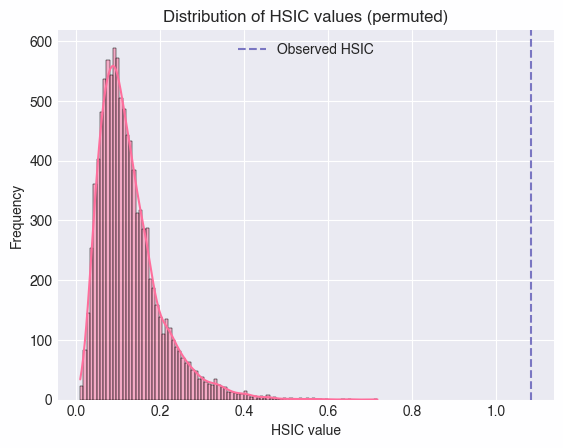

In [30]:
# Plot the distribution of permuted HSIC values
sns.histplot(permuted_hsics, color="#ff6e9c98", kde=True)
plt.axvline(original_hsic, linestyle='--', label='Observed HSIC')
plt.xlabel('HSIC value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of HSIC values (permuted)')
plt.show()

## Determine Significance of Features with BAHSIC

In [31]:
categories = ["Asian", "Black/Hispanic", "Indian", "White", "Female", "Male", "Freshmen", "Junior", "Senior", "Sophomore", "Android", "iPhone", "Goon", "Not Goon", "STEM", "not STEM", "Band/Orchestra/CG", "not in Music", "Instagram"]

def hsic(X, y, kernel='rbf'):
    m = X.shape[0]
    H = np.eye(m) - np.ones((m, m)) / m
    K = pairwise_kernels(X, metric=kernel)
    L = pairwise_kernels(y.values.reshape(-1, 1), metric=kernel)
    return np.trace(np.dot(np.dot(K, H), np.dot(L, H))) / (m ** 2)

def bahsic(X, y, kernel='rbf', n_remove=1):
    n_features = X.shape[1]
    feature_indices = list(range(n_features))
    ordered_features = []
    end = False

    while len(feature_indices) > 0:
        hsic_values = []
        for i in feature_indices:
            subset_indices = [j for j in feature_indices if j != i]
            if len(subset_indices) == 0:
                end = feature_indices[0]
                break
            X_subset = X[:, subset_indices]
            hsic_value = hsic(X_subset, y, kernel)
            hsic_values.append(hsic_value)

        if not end:
            min_hsic_index = np.argmax(hsic_values)
            removed_feature = feature_indices.pop(min_hsic_index)
            ordered_features.append(removed_feature)
            print(f"Removed feature index: {removed_feature}, feature name: {categories[removed_feature]} HSIC value: {hsic_values[min_hsic_index]}")
        else:
            ordered_features.append(end)
            break
    return ordered_features[::-1]

# Run BAHSIC on the dataset
ordered_features = bahsic(X_processed, y, kernel='rbf')
print(f"Ordered feature indices (from most to least important): {ordered_features}")

# Map ordered feature indices back to original feature names
ordered_feature_names = [categories[i] for i in ordered_features]
print(f"Ordered feature names (from most to least important): {ordered_feature_names}")


Removed feature index: 3, feature name: White HSIC value: 0.009471452782795731
Removed feature index: 6, feature name: Freshmen HSIC value: 0.009858847759575016
Removed feature index: 7, feature name: Junior HSIC value: 0.010287619479792844
Removed feature index: 8, feature name: Senior HSIC value: 0.010742710930160687
Removed feature index: 9, feature name: Sophomore HSIC value: 0.01127016298029195
Removed feature index: 5, feature name: Male HSIC value: 0.011839811812820955
Removed feature index: 13, feature name: Not Goon HSIC value: 0.01243928351826114
Removed feature index: 14, feature name: STEM HSIC value: 0.013152858499849622
Removed feature index: 4, feature name: Female HSIC value: 0.014377913165886795
Removed feature index: 12, feature name: Goon HSIC value: 0.01575629684037111
Removed feature index: 2, feature name: Indian HSIC value: 0.017422293481238086
Removed feature index: 10, feature name: Android HSIC value: 0.01937795460865624
Removed feature index: 11, feature name

## Other Visualizations
### Distribution of Weighted Points

(array([ 2.,  0., 10.,  1.,  0., 12.,  0.,  0.,  0., 19.,  0.,  0., 11.,
         2.,  0.,  0., 22.,  0.,  0., 15.]),
 array([-2.01867707, -1.84727989, -1.67588272, -1.50448555, -1.33308838,
        -1.1616912 , -0.99029403, -0.81889686, -0.64749969, -0.47610251,
        -0.30470534, -0.13330817,  0.03808901,  0.20948618,  0.38088335,
         0.55228052,  0.7236777 ,  0.89507487,  1.06647204,  1.23786922,
         1.40926639]),
 <BarContainer object of 20 artists>)

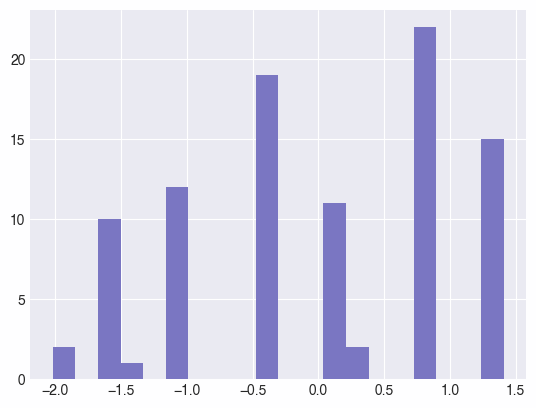

In [32]:
plt.hist(df["std_weighted_points"], bins=20)

### Distribution of Time spent watching video

(array([ 3.,  6.,  6.,  9.,  8., 10.,  9.,  7.,  6.,  4.,  5.,  4.,  5.,
         2.,  1.,  2.,  0.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-1.33600381, -1.16781864, -0.99963346, -0.83144828, -0.6632631 ,
        -0.49507792, -0.32689275, -0.15870757,  0.00947761,  0.17766279,
         0.34584797,  0.51403314,  0.68221832,  0.8504035 ,  1.01858868,
         1.18677386,  1.35495904,  1.52314421,  1.69132939,  1.85951457,
         2.02769975,  2.19588493,  2.3640701 ,  2.53225528,  2.70044046,
         2.86862564,  3.03681082,  3.204996  ,  3.37318117,  3.54136635,
         3.70955153,  3.87773671,  4.04592189,  4.21410706,  4.38229224,
         4.55047742,  4.7186626 ,  4.88684778,  5.05503295,  5.22321813,
         5.39140331]),
 <BarContainer object of 40 artists>)

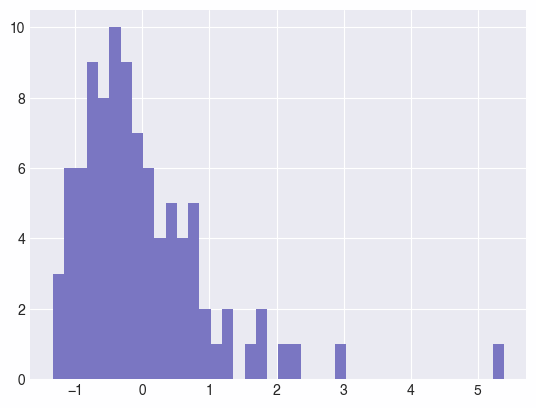

In [33]:
plt.hist(df["std_t1"], bins=40)

### Distribution of Combined Brainrot Index

No handles with labels found to put in legend.


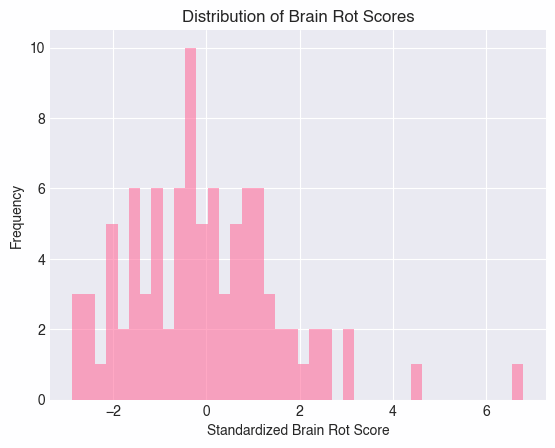

In [34]:
plt.hist(df["std_sum"], bins=40, color="#ff6e9c98")
plt.xlabel('Standardized Brain Rot Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Brain Rot Scores')
plt.show()

## Other Data Analysis

No handles with labels found to put in legend.


Text(0.5, 1.0, "Brainrot of each Person by Respondent's Gender")

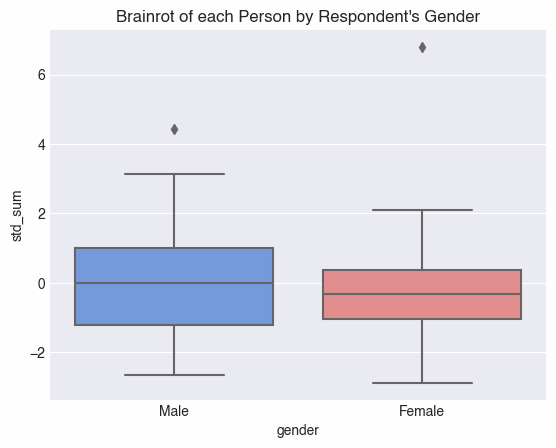

In [35]:
my_pal = {"Male": "cornflowerblue", "Female": "lightcoral"}
sns.boxplot(data=df, x="gender", y="std_sum", palette=my_pal, dodge=True)
plt.legend(loc="lower left")
plt.title("Brainrot of each Person by Respondent's Gender")

No handles with labels found to put in legend.


Text(0.5, 1.0, "Brainrot of each Person by Respondent's Race")

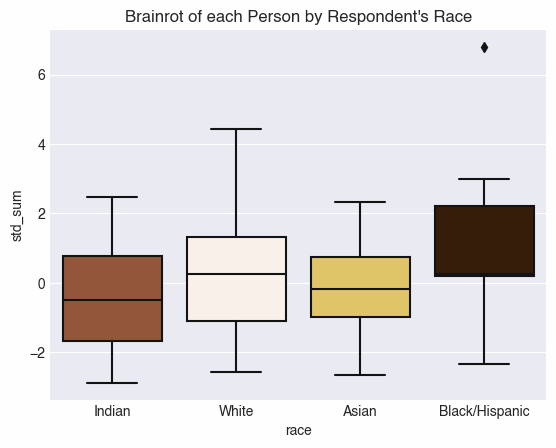

In [36]:
my_pal = {"Indian": "sienna", "Asian": "xkcd:maize", "White":"linen", "Latino":"xkcd:dark tan", "Black":"xkcd:chocolate", "Black/Hispanic":"xkcd:chocolate"}
sns.boxplot(data=df, x="race", y="std_sum", palette=my_pal, dodge=True)
plt.legend(loc="lower left")
plt.title("Brainrot of each Person by Respondent's Race")

Text(0.5, 1.0, "Brainrot of each Person by Respondent's goon")

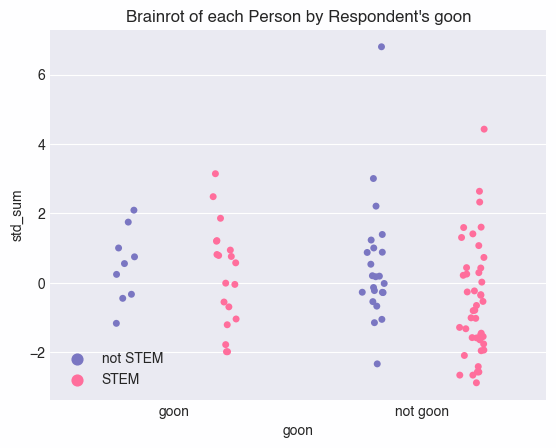

In [37]:
factor = "goon"
sns.stripplot(data=df, x=factor, hue="stem", y="std_sum", dodge=True)
plt.legend(loc="lower left")
plt.title(f"Brainrot of each Person by Respondent's {factor}")

No handles with labels found to put in legend.


Text(0.5, 1.0, "Brainrot of each Person by Respondent's musical elective")

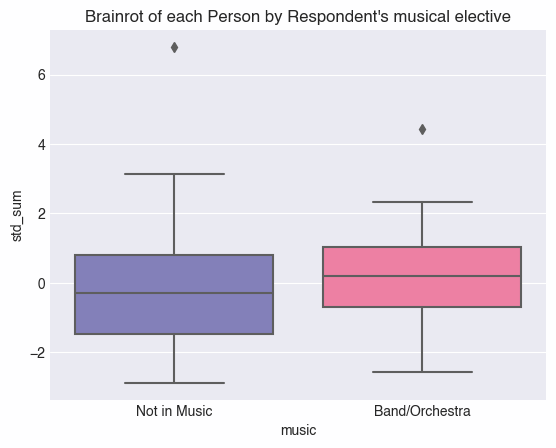

In [38]:
my_pal = {"Indian": "sienna", "Asian": "xkcd:maize", "White":"linen", "Latino":"xkcd:dark tan", "Black":"xkcd:very dark brown"}
sns.boxplot(data=df, x="music", y="std_sum", dodge=True)
plt.legend(loc="lower left")
plt.title("Brainrot of each Person by Respondent's musical elective")

Text(0.5, 1.0, "Brainrot of each Person by Respondent's gender and response to Drake Snake")

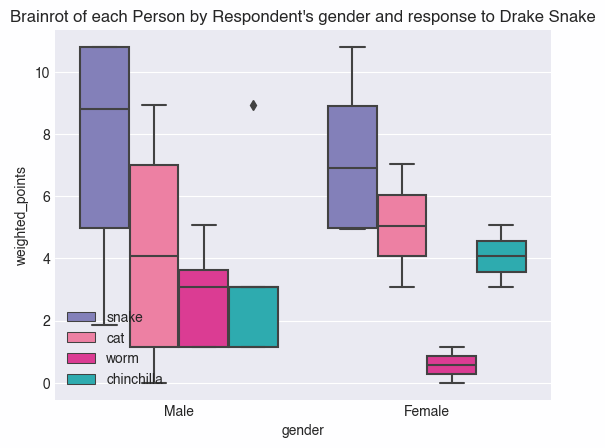

In [39]:
my_pal = {"Male": "cornflowerblue", "Female": "lightcoral"}
sns.boxplot(data=df, x="gender", y="weighted_points", hue="q7", dodge=True)
plt.legend(loc="lower left")
plt.title("Brainrot of each Person by Respondent's gender and response to Drake Snake")

## Relationship between number of Instagram followers and Brainrot

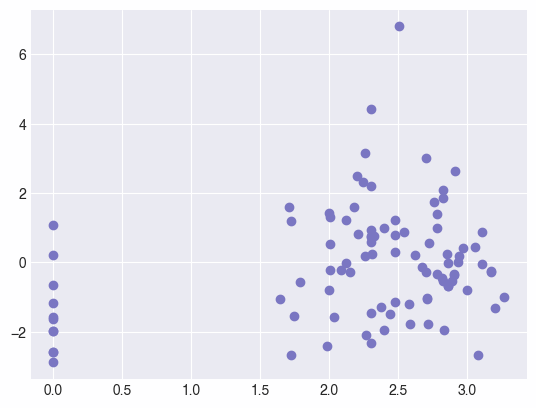

In [40]:
plt.scatter(x=df["insta"], y=df["std_sum"])

### Running Regression Analysis on Instagram and Brainrot

In [41]:
df2 = df.dropna()

Y = df2["insta"]
X = df2["std_sum"]
X = sm.add_constant(X)
model = sm.OLS(Y,X)

results = model.fit()

In [42]:
print(results.params)
print(results.tvalues)
print(results.t_test([1, 0]))

const      2.216965
std_sum    0.147067
dtype: float64
const      24.790105
std_sum     2.671145
dtype: float64
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.2170      0.089     24.790      0.000       2.039       2.395


In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  insta   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     7.135
Date:                Mon, 23 Sep 2024   Prob (F-statistic):            0.00894
Time:                        20:40:02   Log-Likelihood:                -118.95
No. Observations:                  94   AIC:                             241.9
Df Residuals:                      92   BIC:                             247.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2170      0.089     24.790      0.000       2.039       2.395
std_sum        0.1471      0.055      2.671      0.009       0.038       0.256
==============================================================================
Omnibus:                       22.650   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.217
Skew:                          -1.271   Prob(JB):                     4.53e-07
Kurtosis:                       3.999   Cond. No.                         1.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""